In [62]:
import numpy as np
import os, sqlite3, pickle, sys, gzip, shutil, time
from tqdm import tqdm
import os.path as osp

from pandas import read_sql, concat
from sklearn.preprocessing import normalize, RobustScaler
from sklearn.neighbors import kneighbors_graph as knn
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from spektral.data import Dataset, Graph
import tensorflow as tf

In [63]:
features = ["dom_x", "dom_y", "dom_z", "time", "charge_log10"]
targets  = ["energy_log10", "position_x", "position_y", "position_z", "direction_x", "direction_y", "direction_z"]

muon = True

In [64]:
spec='muon0'
path='data/loaddata'
db_file='data/rasmus_classification_muon_3neutrino_3mio.db'
db_folder='data'
skip=1
n_data=1e5
n_data=int(n_data)
n_neighbors = 6 # this is a hyperparam optimization
if os.path.isfile(path):
    # Make output folder
    os.mkdir(path)

print("Connecting to db-file")
with sqlite3.connect(db_file) as conn:
    # Find indices to cut after
    try:
        if muon:
            start_id = conn.execute(f"select distinct event_no from features where event_no > 130000000 limit 1 offset {skip}").fetchall()[0][0]
            stop_id  = conn.execute(f"select distinct event_no from features where event_no > 130000000 limit 1 offset {skip + n_data}").fetchall()[0][0]
        else:
            start_id = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip}").fetchall()[0][0]
            stop_id  = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip + self.n_data}").fetchall()[0][0]
    except:
        start_id = 0
        stop_id  = 999999999

    # SQL query format
    feature_call = ", ".join(features)
    target_call  = ", ".join(targets)

    # Load data from db-file
    print("Reading files")
    df_event = read_sql(f"select event_no       from features where event_no >= {start_id} and event_no < {stop_id}", conn)
    df_feat  = read_sql(f"select {feature_call} from features where event_no >= {start_id} and event_no < {stop_id}", conn)
    df_targ  = read_sql(f"select {target_call } from truth    where event_no >= {start_id} and event_no < {stop_id}", conn)

#     transformers = pickle.load(open(osp.join(db_folder, "transformers.pkl"), 'rb'))
#     trans_x      = transformers['features']
#     trans_y      = transformers['truth']


#     for col in df_feat.columns:
#         df_feat[col] = trans_x[col].inverse_transform(np.array(df_feat[col]).reshape(1, -1)).T

#     for col in df_targ.columns:
#         df_targ[col] = trans_y[col].inverse_transform(np.array(df_targ[col]).reshape(1, -1)).T



    # Cut indices
    print("Splitting data to events")
    idx_list    = np.array(df_event)
    x_not_split = np.array(df_feat)

    _, idx, counts = np.unique(idx_list.flatten(), return_index = True, return_counts = True) 
    xs          = np.split(x_not_split, np.cumsum(counts)[:-1])

    ys          = np.array(df_targ)



    # Generate adjacency matrices
    print("Generating adjacency matrices")
    graph_list = []
    for x, y in tqdm(zip(xs, ys), total = len(xs)):
        a = knn(x[:, :3], n_neighbors)



        graph_list.append(Graph(x = x, a = a, y = y))

    graph_list = np.array(graph_list, dtype = object)


    print("Saving dataset")
    pickle.dump(graph_list, open(osp.join(path, "graph"+spec+".dat"), 'wb'))

Connecting to db-file
Reading files
Splitting data to events


  0%|                                                                             | 53/100000 [00:00<03:09, 528.43it/s]

Generating adjacency matrices


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:15<00:00, 1326.11it/s]


Saving dataset


In [65]:
xs[0][0,:3] # x,y,z of dom

array([ 1.29448004, -1.62512565,  0.77430965])

In [66]:
a=graph_list[0]
a=a.a

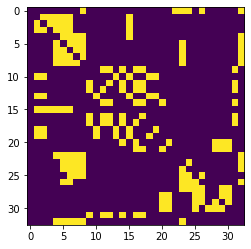

In [67]:
plt.imshow(a.toarray())

In [68]:
df_targ

,energy_log10,position_x,position_y,position_z,direction_x,direction_y,direction_z
0,-1.265877,-0.047820,-0.269170,-0.110488,0.033199,0.127796,-0.466724
1,-1.368341,-0.210812,0.268043,-0.088578,0.140825,-1.226674,0.622130
2,-1.347992,0.287188,-0.162080,-0.190609,0.117596,1.212839,0.538479
3,-1.247069,0.677499,-0.074929,-0.216272,-0.282143,0.794448,1.312213
4,-1.411470,0.393770,-0.107932,-0.234591,-1.099827,0.162114,0.997959
...,...,...,...,...,...,...,...
99995,-0.836112,-0.348856,-0.116874,-0.224072,0.291845,-1.177078,0.355751
99996,-0.614421,-0.212948,0.091922,-0.033170,0.667239,0.236223,-0.289984
99997,-0.955620,-0.188758,-0.190015,-0.255699,-0.229424,-1.168897,0.835978
99998,-1.127637,0.000874,0.177569,-0.253500,0.273006,1.143254,0.285294
